## Project name: Sentiment Analysis for Financial News

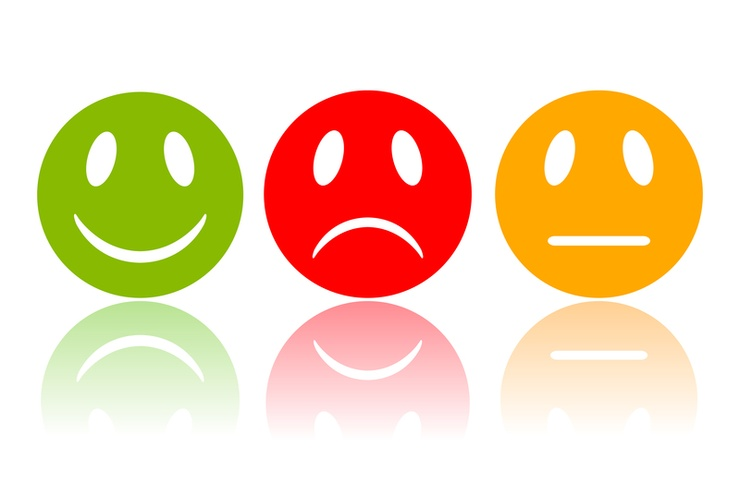

In [1]:
# import the required libraries
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(rc={'figure.figsize':(8,6)})

In [2]:
# load the english language library
nlp = spacy.load('en_core_web_sm')

In [3]:
# loading the data
df = pd.read_csv('data.csv', encoding = "ISO-8859-1", header=None)
df.columns = ["sentiment","news_headline"]

Let's first see how our data looks like

In [4]:
# shape of the data
df.shape

(4846, 2)

In [5]:
# display the first 5 rows in our dataframe
df.head()

,sentiment,news_headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


### Data Analysis

Here we're gonna explore our data to check if there is any trends.

Let's now see the distribution of sentiments across all the news headlines.

neutral     59.41
positive    28.13
negative    12.46
Name: sentiment, dtype: float64


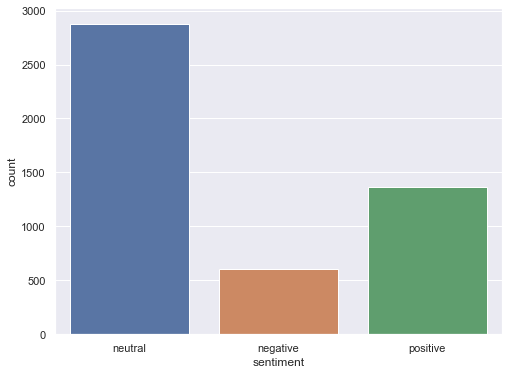

In [6]:
print(round(df.sentiment.value_counts(normalize=True)*100,2))
sns.countplot(x="sentiment", data=df);

Here from the plot above we can see that our data is clearly umbalanced. The majority of the headlines are neural followed by the positives and then the negative sentiments.

In [7]:
# check for missing values
df.isnull().sum()

sentiment        0
news_headline    0
dtype: int64

No missing values in our data. But we still have to check if there are any blank records and remove them.

In [8]:
# remove NaN values and empty strings
def remove_null(data):

    # remove NaN values
    if data.isnull().sum().sum()>0:
        data.dropna(inplace=True)

    # remove any blank records
    blanks = []                                         # start with an empty list

    for index,sentiment,headline in data.itertuples():  # iterate over the DataFrame
        if type(headline)==str:                         # avoid NaN values
            if headline.isspace():                      # test 'headline' for whitespace
                blanks.append(index)                    # add matching index numbers to the list

    if blanks:
        data.drop(blanks, inplace=True)
        
        
remove_null(df)

### Data Cleaning

In [9]:
from spacy.lang.en.stop_words import STOP_WORDS
import string

stopwords = list(STOP_WORDS)
punct = string.punctuation

# create a function that performs text data cleaning
def textDataCleaning(sentence):
    """ 
    In this function we will go through tokenizing, lemmitization, converting to lower-case, 
    removing stop words and removing any punctuations 
    
    """
    # creating our document object
    doc = nlp(sentence)
    
    tokens = []
    
    # lemmatizing each token and converting each one into lowercase
    for token in doc:
        if token.lemma_ != "-PRON-":
            lower = token.lemma_.lower().strip()
        else:
            lower = token.lower()
        
        tokens.append(lower)
    
    cleaned_tokens = []
    
    # removing stop words and punctuations
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
            
    # return cleaned list of tokens
    return cleaned_tokens

### Data Preprocessing

In NLP projects, the most important part is preprocessing the data, so that it is ready for a model to use. That’s what we are doing now.

Let's extract and store the input and the output, which is the sentiment and the news headlines

In [10]:
# divide our dataset into input and output sets
X = df['news_headline']
y = df['sentiment']

In [11]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=42)

In [12]:
# display the shape of train and test data
X_train.shape , X_test.shape

((3876,), (970,))

Statistical algorithms use mathematics to train machine learning models. However, mathematics only work with numbers. To make statistical algorithms work with text, we first have to convert text to numbers.

Python's Scikit-Learn library contains the `TfidfVectorizer` class that can be used to convert text features into TF-IDF feature vectors.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=textDataCleaning)

### Training the model

Once data is split into training and test set, machine learning algorithms can be used to learn from the training data. You can use any machine learning algorithm. However, we will use the Random Forest algorithm, owing to its ability to act upon non-normalized data.

The sklearn.ensemble module contains the RandomForestClassifier class that can be used to train the machine learning model using the random forest algorithm. To do so, we need to call the fit method on the RandomForestClassifier class and pass it our training features and labels, as parameters. 

Next we're gonna try the folloing model as well:

* AdaBoostClassifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
RF_classifier = RandomForestClassifier(n_estimators=300, criterion='entropy', random_state=42)

# write a pipeline
clf_pipeline = Pipeline([('tfidf', tfidf),('clf', RF_classifier)])

# fitting the model
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function textDataCleaning at 0x000001D59FB4E3A0>)),
                ('clf',
                 RandomForestClassifier(criterion='entropy', n_estimators=300,
                                        random_state=42))])

### Making predictions and Evaluating the model

Once the model has been trained, the last step is to make predictions on the model. To do so, we need to call the predict method on the object of the RandomForestClassifier class that we used for training.

In [15]:
predictions = clf_pipeline.predict(X_test)

Finally, to evaluate the performance of the machine learning models, we can use classification metrics such as a confusion metrix, F1 measure, accuracy, etc.

To find the values for these metrics, we can use classification_report, confusion_matrix, and accuracy_score utilities from the sklearn.metrics library. 

In [16]:
def evaluation(test_data,predictions):
    
    # Classification report, accuracy, precision and recall
    print('---------Classification report---------\n')
    print(classification_report(y_test,predictions))
    print('\n\n---------Scores---------\n')
    print(f"Accuracy:  {round(accuracy_score(y_test, predictions),2)} %")
    print(f"Precision: {round(precision_score(y_test, predictions, average='weighted'),2)} %")
    print(f"Recall:    {round(recall_score(y_test, predictions, average='weighted'),2)} %")

    # plotting the confusion matrix
    print('\n\n---------Confusion matrix---------')
    sns.heatmap(confusion_matrix(y_test,predictions),annot=True,cmap="Greens",fmt='d',
                xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.show()

---------Classification report---------

              precision    recall  f1-score   support

    negative       0.84      0.39      0.53       110
     neutral       0.74      0.96      0.83       571
    positive       0.78      0.46      0.58       289

    accuracy                           0.75       970
   macro avg       0.79      0.61      0.65       970
weighted avg       0.76      0.75      0.72       970



---------Scores---------

Accuracy:  0.75 %
Precision: 0.76 %
Recall:    0.75 %


---------Confusion matrix---------


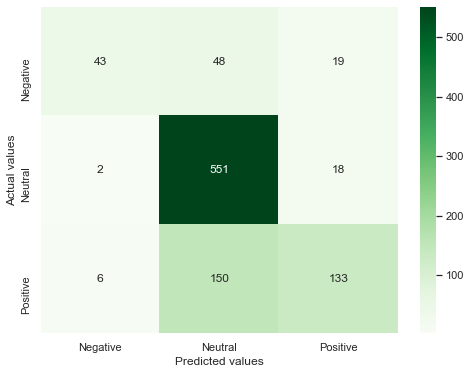

In [17]:
evaluation(y_test,predictions)

#### Train the AdaBoostClassifier

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ADclassifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100)
clf_pipeline = Pipeline([('tfidf', tfidf),('clf', ADclassifier)])
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function textDataCleaning at 0x000001D59FB4E3A0>)),
                ('clf',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                    n_estimators=100))])

In [19]:
predictions = clf_pipeline.predict(X_test)

---------Classification report---------

              precision    recall  f1-score   support

    negative       0.70      0.45      0.54       110
     neutral       0.75      0.92      0.83       571
    positive       0.72      0.49      0.59       289

    accuracy                           0.74       970
   macro avg       0.72      0.62      0.65       970
weighted avg       0.74      0.74      0.72       970



---------Scores---------

Accuracy:  0.74 %
Precision: 0.74 %
Recall:    0.74 %


---------Confusion matrix---------


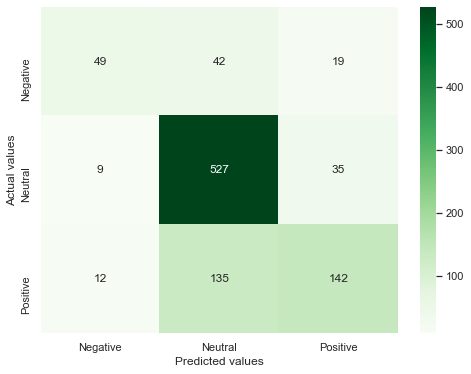

In [20]:
evaluation(y_test,predictions)